# Dataset exploration

## Graphing a stock

Retrieved data on 6987 symbols, from A to ZYXI
Showing graph for AMZN


Text(0.5, 1.0, 'Daily closing price for AMZN')

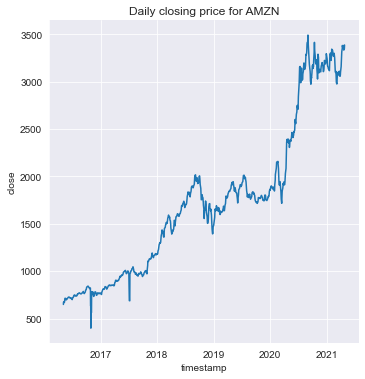

In [12]:
from typing import Dict, List, Tuple

import numpy as np
import seaborn as sns
from alpaca_trade_api.rest import TimeFrame
from matplotlib import pyplot as plt
from scipy.stats import zscore

from lmbda.data.store.PandasBarsDataStore import PandasBarsDataStore

sns.set_style("darkgrid")
sns.color_palette("crest", as_cmap=True)

store = PandasBarsDataStore(timeframe=TimeFrame.Day, data_dir="../../data/history/daily")
symbols = sorted(list(store.symbols()))

symbol = "AMZN" # random.choice(symbols)
print(f"Retrieved data on {len(symbols)} symbols, from {symbols[0]} to {symbols[-1]}")
print(f"Showing graph for {symbol}")
df = store[symbol]

df["close"] = df["close"].rolling(3).mean()
ax = sns.relplot(x=df.index, y="close", kind="line", data=df)
plt.title(f"Daily closing price for {symbol}")

## Edge Detection
This is an algorithmic approach to a constant fraction discriminator, which works by dividing a signal in two, delaying one part
by the edge width, inverting the other, adding them together, and watching for zero crossing points. In this case we use
a pre-configured edge width on a stock's close.

![Constant fraction discriminator diagram](https://upload.wikimedia.org/wikipedia/commons/d/d7/CFD_Diagram1.jpg)

The result of the CFD function will be another dataframe that maps a percent change to a series of closing prices,
including back history if desired. This function tries to conserve memory when possible by freeing old dataframes,
as a cost-saving measure for if/when it gets deployed to a lambda.

In [13]:
from datetime import timedelta
import pandas as pd

def perform_cfd(df: pd.DataFrame,
                                             edge_width: timedelta,
                                             back_history: int=0,
                                             pct_change_threshold=0.05,
                                             outlier_zscore_threshold=3.0
                                             ) -> List[Tuple[float, List[float]]]:
    """
    Perform constant fraction discrimination to find rising & falling edges
    :param df: Dataframe of stock closing prices
    :param edge_width: Edge width to consider when doing constant fraction discrimination
    :param back_history: Days of back-history to include in the returned datafraem
    :param pct_change_threshold: Absolute percent change required to be considered a viable edge
    :param outlier_zscore_threshold: Z-score threshold for filtering outliers
    :return: A dataframe mapping percent changes to days of history leading up to them."""

    cfd = df["close"]\
        .to_frame()\
        .rename({"close": "delayed"}, axis=1)\
        .shift(freq=edge_width)\
        .join(-df["close"]
              .to_frame()
              .rename({"close": "inverse"}, axis=1), on="timestamp", how="inner")\
        .dropna(axis=0)

    cfd_results = cfd["delayed"] + cfd["inverse"]
    crossings = np.asarray(np.where(np.diff(np.sign(cfd_results))))[0]
    del cfd
    del cfd_results

    df_deltas = pd.DataFrame({
        "idx": crossings,
        "start": df.iloc[crossings]["close"].array,
        "end": df.iloc[crossings + 1]["close"].array
    }, index=df.iloc[crossings].index).dropna().iloc[1:]
    del crossings

    df_deltas["diff"] = df_deltas.start - df_deltas.end
    df_deltas["pct_diff"] = 100.0 * df_deltas["diff"] / df_deltas.start
    df_deltas = df_deltas[(np.abs(zscore(df_deltas.pct_diff)) < outlier_zscore_threshold) & (df_deltas.pct_diff.abs() >= pct_change_threshold)]

    trailing_histories: List[Tuple[float, List[float]]] = []
    for index, row in df_deltas.iterrows():
        if row.idx - 1 - back_history < 0 or row.idx + 1 > len(df):
            continue
        slice_start = int(row.idx - 1 - back_history)
        slice_end = int(row.idx) + 1
        trailing_histories.append((row.pct_diff, list(df.iloc[slice_start:slice_end]["close"].array)))
    return list(filter(lambda history: float('NaN') not in history[1], trailing_histories))
    # return pd.DataFrame(trailing_histories).dropna(axis=1)

## Mapping *All* Symbols to CFD Tables

This is a big one -- for every symbol in the store, generate a CFD table with 30 days of back history.

In [ ]:
print(f"Generating CFD tables w/back-history for {len(symbols)} symbols...")
cfd_tables: Dict[str, List[Tuple[str, List[float]]]] = {}
# data = store["AAL"]
# perform_cfd(data, edge_width=timedelta(3), back_history=30, pct_change_threshold=1.0)
for i, symbol in enumerate(symbols):
    if i % 100 == 0:
	    print(f"Processing {symbol} ({100 * i / len(symbols):.2f}% complete)")
    cfd_tables[symbol] = perform_cfd(store[symbol], edge_width=timedelta(3), back_history=30, pct_change_threshold=1.0)
print("Done!")

Generating CFD tables w/back-history for 6987 symbols...
Processing A (0.00% complete)
Processing ADC (1.43% complete)
Processing AGGRU (2.86% complete)
Processing ALNY (4.29% complete)
Processing ANVS (5.72% complete)
Processing ARRY (7.16% complete)
Processing AU (8.59% complete)
Processing BATL (10.02% complete)
Processing BGH (11.45% complete)
Processing BMA (12.88% complete)
Processing BSIG (14.31% complete)
Processing CAMT (15.74% complete)
Processing CEE (17.17% complete)
Processing CHSCM (18.61% complete)
Processing CMII (20.04% complete)
Processing COVA (21.47% complete)
Processing CSTA (22.90% complete)
Processing CYCCP (24.33% complete)
Processing DHF (25.76% complete)
Processing DSWL (27.19% complete)
Processing EFL (28.62% complete)


Finally, we'll save the data for future use.

In [ ]:
import pickle

with open("../../data/cfds.pkl", "wb") as file:
    pickle.dump(cfd_tables, file)